# Pupillometry example data

This notebook shows how to generate the figures with pupil-size data from:

- Mathôt, S. (in prep). How do pupil responses help us to better see the world? *Journal of Cognition*


## Loading the data

We start with some boilerplate code. First off, some `import`s and constants.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from datamatrix import plot
from datamatrix.colors.tango import blue, red
from datamatrix import functional as fnc, series as srs, operations as ops
from eyelinkparser import parse, defaulttraceprocessor


ON = 10000
OFF = 20000
SOUND_ON = 1000
SOUND_OFF = 9000
FIGSIZE = 10, 5
X = np.linspace(0, 30, 30000)
X_SOUND = np.linspace(0, 10, 10000)

Initializing cache ...


And we need a function to read and parse the data, which in the `.asc` format of the EyeLink. For more information about this, see `python-eyelinkparser` package. We decorate the function with a persistent memoization, which means that the return will be cached and written to disk, so that we don't need to reparse the data over and over again.

In [2]:
@fnc.memoize(persistent=True)
def get_data():
    
    dm = parse(
        traceprocessor=defaulttraceprocessor(blinkreconstruct=True)
    )
    dm.ptrace_stimon.depth = ON
    dm.ptrace_stimoff.depth = OFF
    dm.pupil = srs.concatenate(
        dm.ptrace_stimon,
        dm.ptrace_stimoff
    )
    dm.pupil = srs.baseline(
        dm.pupil,
        dm.ptrace_adaptation,
        -10, -1,
        method='divisive'
    )    
    dm.ptrace_stimon.depth = SOUND_ON
    dm.ptrace_stimoff.depth = SOUND_OFF
    dm.pupil_sound = srs.concatenate(
        dm.ptrace_stimon,
        dm.ptrace_stimoff
    )
    dm.pupil_sound = srs.baseline(
        dm.pupil_sound,
        dm.ptrace_adaptation,
        -10, -1,
        method='divisive'
    )    
    dm.stimcolor = fnc.map_(
        lambda s: 'red' if s == 'rgb(74%,0%,0%)' else 'blue',
        dm.stimcolor
    )
    dm = ops.keep_only(dm, dm.condition, dm.pupil, dm.pupil_sound, dm.stimcolor)
    return dm

Now get the data.

In [3]:
dm = get_data()
print(dm)

+----+---------------+-------------------------------------------------------+-------------------------------------------------------+-----------+
| #  |   condition   |                         pupil                         |                      pupil_sound                      | stimcolor |
+----+---------------+-------------------------------------------------------+-------------------------------------------------------+-----------+
| 0  | lightresponse | [ 0.9987946   0.99783028 ...  0.98023144  0.98047252] | [ 0.9987946   0.99783028 ...  0.94575699  0.94551591] |    red    |
| 1  | lightresponse | [ 1.00046926  0.99976537 ...  0.97137494  0.97137494] | [ 1.00046926  0.99976537 ...  0.9450962   0.94603473] |    blue   |
| 2  | lightresponse | [ 0.99811009  0.99787385 ...  0.96102055  0.96102055] | [ 0.99811009  0.99787385 ...  0.92582093  0.92605717] |    red    |
| 3  | lightresponse | [ 0.99952313  0.99952313 ...  0.95922747  0.9587506 ] | [ 0.99952313  0.99952313 ...  0.8855507

## Pupil light response

Now let's plot the pupil light reponse. There are two different colors: blue and red.

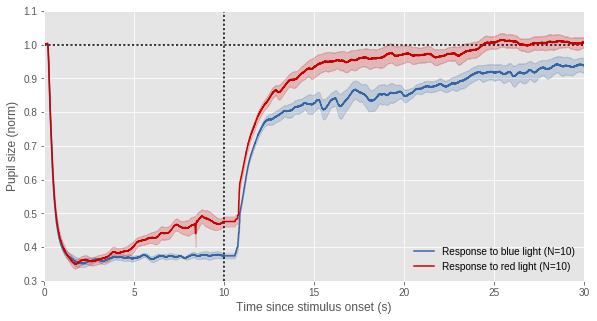

In [7]:
plot.new(size=FIGSIZE)
plt.ylim(0.3,1.1)
plt.xlim(0, 30)
plt.axvline(10, color='black', linestyle=':')
plt.axhline(1, color='black', linestyle=':')
for stimcolor, _dm in ops.split((dm.condition == 'lightresponse').stimcolor):
    plot.trace(
        _dm.pupil,
        x=X,
        color=blue[1] if stimcolor == 'blue' else red[1],
        label='Response to %s light (N=%d)' % (stimcolor, len(_dm))
    )
plt.ylabel('Pupil size (norm)')
plt.xlabel('Time since stimulus onset (s)')
plt.legend(frameon=False)
plt.savefig('lightresponse.svg')
plt.show()

## Pupil near response

And the pupil near response:

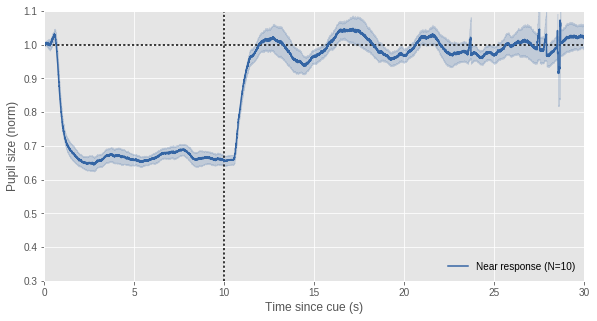

In [5]:
plot.new(size=FIGSIZE)
plt.ylim(0.3,1.1)
plt.xlim(0, 30)
plt.axhline(1, color='black', linestyle=':')
plt.axvline(10, color='black', linestyle=':')
plot.trace((dm.condition == 'nearresponse').pupil, x=X,
    label='Near response (N=%d)' % len(dm.condition == 'nearresponse')
)
plt.legend(frameon=False, loc='lower right')
plt.ylabel('Pupil size (norm)')
plt.xlabel('Time since cue (s)')
plt.savefig('nearresponse.svg')
plt.show()

## Psychosensory response to sound

Finaly, the pupil response to osund.

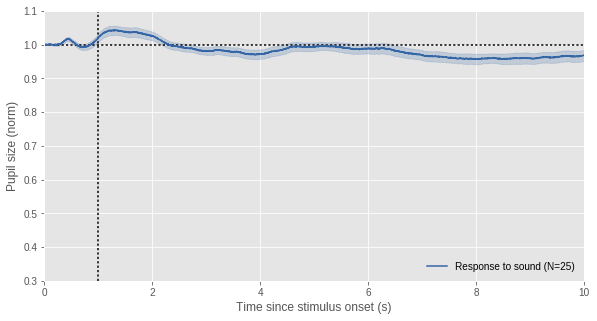

In [6]:
plot.new(size=FIGSIZE)
plt.axhline(1, color='black', linestyle=':')
plt.axvline(1, color='black', linestyle=':')
plt.ylim(0.3,1.1)
plt.xlim(0, 10)
plot.trace((dm.condition == 'sound').pupil_sound, x=X_SOUND,
    label='Response to sound (N=%d)' % len(dm.condition == 'sound')
)
plt.legend(frameon=False, loc='lower right')
plt.ylabel('Pupil size (norm)')
plt.xlabel('Time since stimulus onset (s)')
plt.savefig('sound.svg')
plt.show()